<a href="https://colab.research.google.com/github/rhks13/Remote-Internship/blob/main/3_%EC%B5%9C%EC%A2%85_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EC%A0%84%EC%B2%98%EB%A6%AC_%EB%B0%8F_%EB%AA%A8%EB%8D%B8%EB%A7%81.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
    # 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 5 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (9,216 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pickle
import datetime

In [ ]:
# 데이터 가져오기

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/cj E2-3/data/최종데이터.csv', index_col=0)

In [ ]:
df.pop('주말/공휴일')
df.pop('일시')
df.pop('눈')
df.pop('가해운전자 차종')

0       승용
1       승용
2       승용
3       승용
4       승용
        ..
2718    승용
2719    승용
2720    승용
2721    승용
2722    승용
Name: 가해운전자 차종, Length: 2723, dtype: object

# **1. 모델링**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2723 entries, 0 to 2722
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   사고내용      2723 non-null   int64  
 1   도로형태      2723 non-null   object 
 2   가해운전자 성별  2723 non-null   object 
 3   가해운전자 연령  2723 non-null   int64  
 4   읍면동       2723 non-null   object 
 5   풍속(m/s)   2723 non-null   float64
 6   비         2723 non-null   int64  
 7   도로상태      2723 non-null   object 
 8   사고유형2     2723 non-null   object 
 9   사고유형1     2723 non-null   object 
 10  weather1  2723 non-null   float64
 11  weather2  2723 non-null   float64
dtypes: float64(3), int64(3), object(6)
memory usage: 276.6+ KB


In [ ]:
from sklearn.model_selection import train_test_split
# eda를 분석하기 위해 train셀과 test셀로 나눔
data = df[df.columns.difference(['사고내용'])]
target = df['사고내용']

# train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, shuffle=True, stratify=target, random_state=1)

In [ ]:
# catboost에 사용하기 위해 범주형 피처만 리스트화
cat_features = np.where((x_train.dtypes != np.float)&(x_train.dtypes != np.int))[0].tolist()

cat_features

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


[2, 4, 5, 7, 8, 9]

In [ ]:
!pip install catboost # catboost library install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 


In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

In [ ]:
# 가중치 계산
neg=y_train.value_counts()[0]
pos=y_train.value_counts()[1]
total=len(y_train)
print(neg)
print(pos)
print(total)

1599
579
2178


In [ ]:
# # # total/2 단위로 확장하면 손실 규모도 비슷한 수준으로 유지할 수 있습니다.
# # # 모든 예제의 가중치 합계는 동일합니다.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0



print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.68
Weight for class 1: 1.88


In [ ]:
weights = {0: 1, 1: 3}

In [ ]:
clf_no_weight = CatBoostClassifier(iterations=500,learning_rate=0.2,random_seed=1)
# 가중치 적용 X

In [ ]:
clf = CatBoostClassifier(iterations=500,learning_rate=0.1,random_seed=1,max_depth=8,class_weights=weights)

In [ ]:
params = {'max_depth': [7,8,9], 'iterations' : [500,1000,5000,10000],'learning_rate' : [0.2,0.1,0.05,0.001]}

In [ ]:
clf.fit(x_train,y_train,cat_features=cat_features,eval_set=(x_test,y_test))

0:	learn: 0.6829366	test: 0.6883953	best: 0.6883953 (0)	total: 63.6ms	remaining: 31.7s
1:	learn: 0.6732527	test: 0.6831236	best: 0.6831236 (1)	total: 76.7ms	remaining: 19.1s
2:	learn: 0.6694999	test: 0.6782129	best: 0.6782129 (2)	total: 81.6ms	remaining: 13.5s
3:	learn: 0.6633104	test: 0.6766526	best: 0.6766526 (3)	total: 93.5ms	remaining: 11.6s
4:	learn: 0.6556855	test: 0.6747907	best: 0.6747907 (4)	total: 105ms	remaining: 10.4s
5:	learn: 0.6485262	test: 0.6718306	best: 0.6718306 (5)	total: 120ms	remaining: 9.91s
6:	learn: 0.6446146	test: 0.6702159	best: 0.6702159 (6)	total: 141ms	remaining: 9.94s
7:	learn: 0.6372722	test: 0.6680789	best: 0.6680789 (7)	total: 154ms	remaining: 9.45s
8:	learn: 0.6336563	test: 0.6675681	best: 0.6675681 (8)	total: 165ms	remaining: 9.03s
9:	learn: 0.6326890	test: 0.6674175	best: 0.6674175 (9)	total: 170ms	remaining: 8.34s
10:	learn: 0.6285006	test: 0.6666250	best: 0.6666250 (10)	total: 181ms	remaining: 8.06s
11:	learn: 0.6263620	test: 0.6656440	best: 0.665

# **2. 모델 평가**

In [ ]:
# y_pred 예측
y_pred = clf.predict(data=x_test)
# y_pred = grid_search.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, y_pred)

0.6073394495412844

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_score(y_test, y_pred) 

0.46499999999999997

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred)

array([[238, 162],
       [ 52,  93]])

# **3. 모델 해석**

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 14.0 MB/s 


In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(clf)
shap_values = explainer.shap_values(x_train)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], x_train.iloc[0,:])

Glyph 44032 missing from current font.
Glyph 54644 missing from current font.
Glyph 50868 missing from current font.
Glyph 51204 missing from current font.
Glyph 51088 missing from current font.
Glyph 50672 missing from current font.
Glyph 47161 missing from current font.
Glyph 48708 missing from current font.
Glyph 46020 missing from current font.
Glyph 47196 missing from current font.
Glyph 49345 missing from current font.
Glyph 53468 missing from current font.
Glyph 54413 missing from current font.
Glyph 49549 missing from current font.
Glyph 49457 missing from current font.
Glyph 48324 missing from current font.
Glyph 54805 missing from current font.
Glyph 49324 missing from current font.
Glyph 44256 missing from current font.
Glyph 50976 missing from current font.
Glyph 51021 missing from current font.
Glyph 47732 missing from current font.
Glyph 46041 missing from current font.
Glyph 44032 missing from current font.
Glyph 54644 missing from current font.
Glyph 50868 missing from 

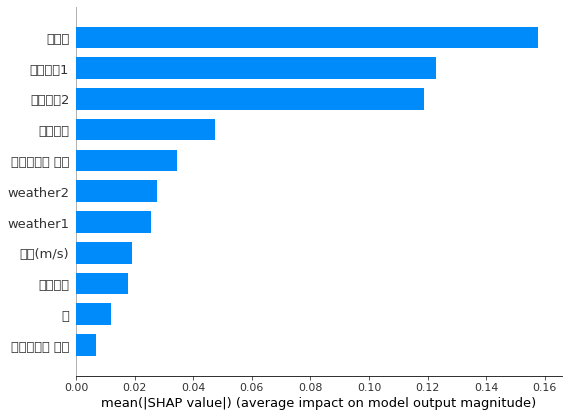

In [ ]:
shap.summary_plot(shap_values, x_train, plot_type="bar",show=False)

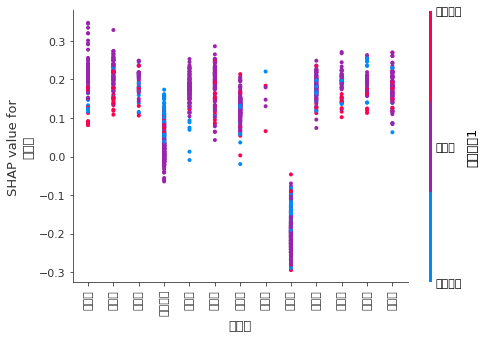

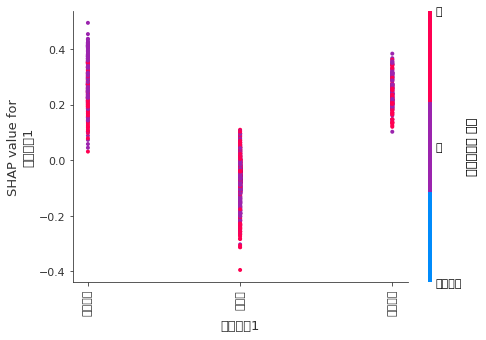

In [ ]:
shap.initjs()
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))  # (13, ) : 각각의 Feature 에 대해 shap value 다 더한 것 

# make SHAP plots of the three most important features
for i in range(2):
    shap.dependence_plot(top_inds[i], shap_values, x_train)

Glyph 44032 missing from current font.
Glyph 54644 missing from current font.
Glyph 50868 missing from current font.
Glyph 51204 missing from current font.
Glyph 51088 missing from current font.
Glyph 50672 missing from current font.
Glyph 47161 missing from current font.
Glyph 48708 missing from current font.
Glyph 46020 missing from current font.
Glyph 47196 missing from current font.
Glyph 49345 missing from current font.
Glyph 53468 missing from current font.
Glyph 54413 missing from current font.
Glyph 49549 missing from current font.
Glyph 49457 missing from current font.
Glyph 48324 missing from current font.
Glyph 54805 missing from current font.
Glyph 49324 missing from current font.
Glyph 44256 missing from current font.
Glyph 50976 missing from current font.
Glyph 51021 missing from current font.
Glyph 47732 missing from current font.
Glyph 46041 missing from current font.
Glyph 44032 missing from current font.
Glyph 54644 missing from current font.
Glyph 50868 missing from 

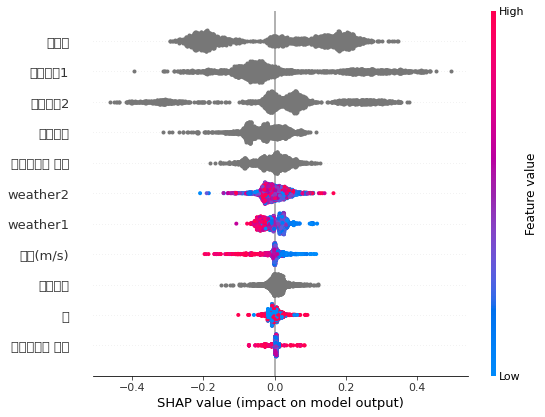

In [ ]:
shap.summary_plot(shap_values,x_train,show=False)

In [ ]:
df

,사고내용,도로형태,가해운전자 성별,가해운전자 연령,읍면동,풍속(m/s),비,도로상태,사고유형2,사고유형1,weather1,weather2
0,0,기타 - 기타,남,29,애월읍,3.4,0,건조,기타,차대차,0.338780,0.014215
1,1,단일로 - 기타,남,42,제주시,1.4,0,건조,차도통행중,차대사람,0.362339,-0.074039
2,1,교차로 - 교차로안,남,47,남원읍,0.7,0,건조,전도전복,차량단독,0.314775,-0.089615
3,0,교차로 - 교차로안,남,24,성산읍,0.2,1,건조,측면충돌,차대차,0.188174,-0.305543
4,0,단일로 - 기타,남,20,성산읍,1.1,0,건조,공작물충돌,차량단독,0.292271,-0.217881
...,...,...,...,...,...,...,...,...,...,...,...,...
2718,0,교차로 - 교차로부근,남,57,제주시,2.5,0,건조,횡단중,차대사람,0.509706,0.188595
2719,0,단일로 - 기타,여,21,제주시,5.4,1,건조,횡단중,차대사람,0.381653,0.061662
2720,0,단일로 - 기타,여,22,한림읍,5.7,1,건조,측면충돌,차대차,0.345769,-0.015916
2721,0,단일로 - 기타,남,22,서귀포시,3.7,1,건조,기타,차대차,0.449413,0.126550


Glyph 51228 missing from current font.
Glyph 51452 missing from current font.
Glyph 49884 missing from current font.
Glyph 49436 missing from current font.
Glyph 44480 missing from current font.
Glyph 54252 missing from current font.
Glyph 50528 missing from current font.
Glyph 50900 missing from current font.
Glyph 51021 missing from current font.
Glyph 49457 missing from current font.
Glyph 49328 missing from current font.
Glyph 50504 missing from current font.
Glyph 45909 missing from current font.
Glyph 47732 missing from current font.
Glyph 54620 missing from current font.
Glyph 47548 missing from current font.
Glyph 44396 missing from current font.
Glyph 51340 missing from current font.
Glyph 51312 missing from current font.
Glyph 52380 missing from current font.
Glyph 45224 missing from current font.
Glyph 50896 missing from current font.
Glyph 54364 missing from current font.
Glyph 49440 missing from current font.
Glyph 45824 missing from current font.
Glyph 51221 missing from 

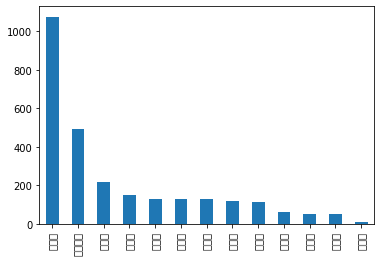

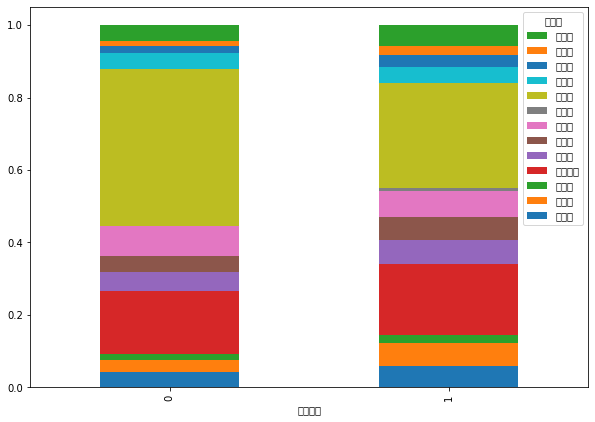

In [ ]:
df['읍면동'].value_counts().plot(kind='bar')
df_obj=df.groupby(['사고내용','읍면동']).count()['비']
df_por=df_obj.unstack().T/df_obj.groupby('사고내용').sum()
df_por.T.plot.bar(stacked=True, legend='reverse', figsize=(10,7))

Glyph 52264 missing from current font.
Glyph 46988 missing from current font.
Glyph 47049 missing from current font.
Glyph 45800 missing from current font.
Glyph 46021 missing from current font.
Glyph 52264 missing from current font.
Glyph 46988 missing from current font.
Glyph 47049 missing from current font.
Glyph 45800 missing from current font.
Glyph 46021 missing from current font.
Glyph 50976 missing from current font.
Glyph 54805 missing from current font.
Glyph 50976 missing from current font.
Glyph 54805 missing from current font.


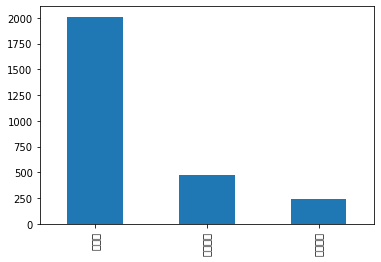

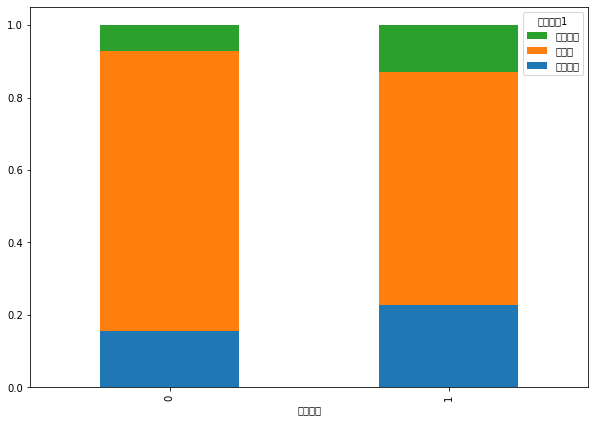

In [ ]:
df['사고유형1'].value_counts().plot(kind='bar')
df_obj=df.groupby(['사고내용','사고유형1']).count()['비']
df_por=df_obj.unstack().T/df_obj.groupby('사고내용').sum()
df_por.T.plot.bar(stacked=True, legend='reverse', figsize=(10,7))

Glyph 44592 missing from current font.
Glyph 53440 missing from current font.
Glyph 52769 missing from current font.
Glyph 52649 missing from current font.
Glyph 46028 missing from current font.
Glyph 52628 missing from current font.
Glyph 54945 missing from current font.
Glyph 51473 missing from current font.
Glyph 44277 missing from current font.
Glyph 51089 missing from current font.
Glyph 47932 missing from current font.
Glyph 53685 missing from current font.
Glyph 54665 missing from current font.
Glyph 54980 missing from current font.
Glyph 51652 missing from current font.
Glyph 51204 missing from current font.
Glyph 48373 missing from current font.
Glyph 44600 missing from current font.
Glyph 44032 missing from current font.
Glyph 51109 missing from current font.
Glyph 51088 missing from current font.
Glyph 47532 missing from current font.
Glyph 50669 missing from current font.
Glyph 47196 missing from current font.
Glyph 50808 missing from current font.
Glyph 51060 missing from 

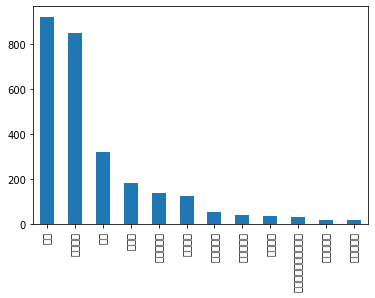

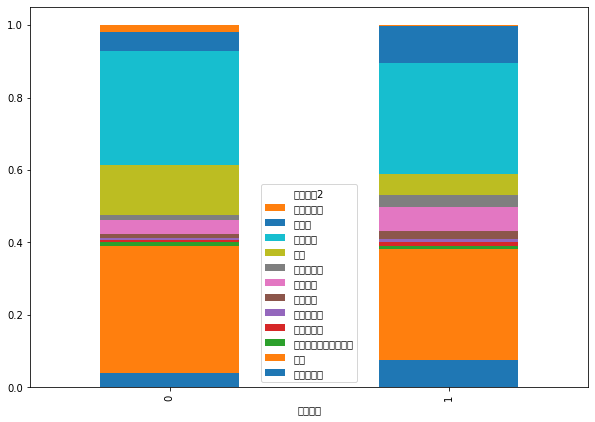

In [ ]:
df['사고유형2'].value_counts().plot(kind='bar')
df_obj=df.groupby(['사고내용','사고유형2']).count()['비']
df_por=df_obj.unstack().T/df_obj.groupby('사고내용').sum()
df_por.T.plot.bar(stacked=True, legend='reverse', figsize=(10,7))